### Milestone 4: Deep learning, due Wednesday, April 26, 2017

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

# Note to grader: because our notebooks are relatively long and complex, we've split them up into two parts.

# This part contains part 1 (the CNN built and tuned from scratch), as well as part of part 3 (the discussion of part 1) and all of part 4 (the exploratory part).

# The other notebook contains part 2 (the pre-trained network) as well as part of part 3 (the discussion of part 2).

# We're sorry that these are disjoint, but it might be easier to run the code this way.

# If you'd like to look at our github to see the data, you can get that here: https://github.com/noahyonack/cs109b_final

In [72]:
import urllib2
import PIL
import os
import numpy as np
import math

# for image manipulati`on. Easier to do 
# here than with Keras, as per
# https://piazza.com/class/ivlbdd3nigy3um?cid=818
#!sudo pip install Image
import PIL.Image as Image
import pandas as pd
from sklearn.metrics import hamming_loss as sk_hamming_loss
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

## Step One: Extracting Movies From URL 

In [74]:
train = pd.read_csv("train_full.csv")
train.drop("Unnamed: 0", axis=1, inplace=True)
# no need for this genre --> only a handful of movies have this
train.drop("10769", axis=1, inplace=True)
print "Train shape:", train.shape
train.head(1)

Train shape: (7220, 31)


,10402,10749,10751,10752,10770,12,14,16,18,27,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,0,0,0,0,0,0,1,0,...,"[u'Amy Adams', u'Jeremy Renner', u'Forest Whit...",329865,Taking place after alien crafts land around th...,25.66195,/hLudzvGfpi6JlwUnsNhXwKKg4j.jpg,2016-11-10,Arrival,False,6.9,3510


In [76]:
train_thinned = pd.read_csv("train.csv")
train_thinned.drop("Unnamed: 0", axis=1, inplace=True)

# no need for this genre --> only a handful of movies have this
try:
    train_thinned.drop("10769", axis=1, inplace=True)
except:
    pass

print "train_thinned shape:", train_thinned.shape
train_thinned.head(1)

train_thinned shape: (540, 29)


,10402,10749,10751,10752,12,14,16,18,27,28,...,lead actors,movie_id,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,0,0,1,0,0,0,1,0,0,0,...,"[u'Alec Baldwin', u'Miles Bakshi', u'Jimmy Kim...",295693,A story about how a new baby's arrival impacts...,305.881041,/unPB1iyEeTBcKiLg8W083rlViFH.jpg,2017-03-23,The Boss Baby,False,5.7,510


## Important. 

The line below aliases the DF that we want to work with as `curr_df`. When we decide later on to use the full training set instead of just `train_thinned`, all we need to do is set it in the cell below and re-run the code. This will prevent us from having to find/replace all instances of the past dataframe.

In [77]:
curr_df = train

# ensure all poster paths are strings
curr_df.poster_path = map(str, curr_df.poster_path)

In [78]:
## Helper that downloads web images 
## Takes in the poster path and the id of the movie 
## Saves the movie as a jpg as the unique id of the movie 
## In the images folder.
def download_web_image(poster_path, movie_id):
    # given that we're going to resize our images to be 32x32
    # or something else really small, let's download really small images 
    # to start
    base_url = "https://image.tmdb.org/t/p/w92/" 
    
    request = urllib2.Request(base_url + poster_path)
    img = urllib2.urlopen(request).read()
    image_name= "all_train_imgs/" + str(movie_id) + ".jpg"
    
    with open(image_name, 'w') as f: 
        f.write(img)

In [79]:
### iterate through all of the images in the thinned dataset, saving locally 
if 1:
    print "If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images."
else:
    for index, row in curr_df.iterrows():
        if index % 200 == 0:
            print index
            
        movie_id = row["movie_id"]
        poster_path = row["poster_path"]
        
        try:
            download_web_image(poster_path, movie_id)
        except:
            continue

If you actually want to download posters, you'll need to turn the `1` above into a `0`. This code doesn't run by default in the notebook so that you don't accidentally download hundreds of images.


In [80]:
img_rows, img_cols = 32, 32

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("all_train_imgs/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("all_train_imgs/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        out.save("all_nn_ready_images/" + img_name)

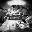

In [81]:
Image.open("all_nn_ready_images/10020.jpg")

# 1. Building a CNN from Scratch

In [82]:
epochs = 50
batch_size = 128

### Data Wrangling

In [83]:
# number of labels in our output
n_labels = 16

In [84]:
# now we need training and testing data. in the current state,
# we have a bunch of greyscale images named by their movie ids.
# to get the data, we can first just split all the movie ids (X) in the
# dataframe intro train and test sets, and then grab their multilabel
# matrices (y)
# m_ids = curr_df.movie_id.values

# gets all movie ids for which we have images
m_ids = map(int, map(lambda x: x[:-4], os.listdir("all_nn_ready_images")))

# shuffle the ids to get a random sample
np.random.shuffle(m_ids)
train_size = int(math.floor(.7 * len(m_ids)))

# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids = m_ids[:train_size]
test_ids = m_ids[train_size:]

In [85]:
# these are the column names of the multilabel matrix
label_names = curr_df.columns[:n_labels]

y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", y_train.shape
print "y_test shape:", y_test.shape

y_train shape: (1813, 16)
y_test shape: (778, 16)


In [86]:
# load image matrices into memory
x_train = np.array([np.asarray(Image.open("all_nn_ready_images/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test =  np.array([np.asarray(Image.open("all_nn_ready_images/" + str(m_id) + ".jpg")) for m_id in test_ids])

In [87]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train.shape
print "x_test shape:", x_test.shape

x_train shape: (1813, 32, 32)
x_test shape: (778, 32, 32)


In [88]:
def reshape(x_train, x_test, img_rows, img_cols):
    # code borrowed from Keras_CNN lab

    # now we need to reshape x_train and x_test so that they work with CNNs
    # Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
    # of images with shape determined by the backend, including the depth dimension,
    # which is 1 for greyscale

    # x_train is of shape n_samples x 32 x 32
    # for a CNN we want to keep the image shape
    # need to explicitly tell keras that it is a gray value image
    # so each image is 32x32x1 not 32x32x3
    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    # normalize image values to [0,1]
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    print "x_train shape:", x_train.shape
    print x_train.shape[0], "train samples"
    print x_test.shape[0], "test samples"
    
    return x_train, x_test, input_shape

In [89]:
x_train, x_test, input_shape = reshape(x_train, x_test, 32, 32)

x_train shape: (1813, 32, 32, 1)
1813 train samples
778 test samples


### Model Architecture

In [102]:
def build_cnn(n_layers, filters, kernels, a_func, input_shape=input_shape, n_labels=n_labels):
    """
    Wrapper function to create a CNN from scratch.
    
    We treat the number of layers, filter size, kernel size, and activation 
    function as parameters which can then be tuned.
    """
    # create an empty network model
    model = Sequential()
    
    for i in range(n_layers):
        # define the input layer to the CNN
        # input shape is a tuple of the # rows, # cols, and # channels (1 for grayscale)
        # the first parameter to Conv2D is the number of filters we want to convolve
        # over the input images
        model.add(Conv2D(filters[i], 
                         kernel_size=kernels[i], 
                         activation=a_func, 
                         input_shape=input_shape)
                 )

        # create a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten for fully connected classification layer
    model.add(Flatten())

    # --- fully connected layer ---
    model.add(Dense(64, activation='relu'))

    # recommended by: https://github.com/fchollet/keras/issues/761
    # uses a sigmoid activation rather than softmax, which apparently
    # gives us a label vector back
    model.add(Dense(n_labels, activation='sigmoid'))

    return model

In [91]:
def compile_cnn(model, loss="binary_crossentropy", lr=0.1, momentum=0.9):
    """
    Compiles a CNNs
    """
    # the setup is our basic categorical crossentropy with stochastic gradient decent
    # we also specify that we want to evaluate our model in terms of accuracy
    sgd = SGD(lr=0.1, momentum=0.9)

    # compile the model
    model.compile(loss=loss,
                  optimizer=sgd,
                  metrics=["accuracy"])

In [92]:
def train_cnn(model=None, x_train=None, y_train=None, x_test=None, y_test=None, batch_size=None, epochs=50):
    """
    Fit the CNN and score it against the test data
    
    Returns (history, score)
    """
    # this is now the actual training
    # in addition to the training data we provide validation data
    # this data is used to calculate the performance of the model over all the epochs
    # this is useful to determine when training should stop
    # in our case we just use it to monitor the evolution of the model over the training epochs
    # if we use the validation data to determine when to stop the training or which model to save, we 
    # should not use the test data, but a separate validation set. 
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        # this will use 30% of the train data as hold out
                        # for validation
                        validation_split=.3)

    # once training is complete, let's see how well we have done
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return history, score

In [93]:
def plot_acc(model_history, baseline=None):
    plt.figure(figsize=(8, 6))

    max_train_acc = round(max(model_history.history['acc']), 2)
    max_test_acc = round(max(model_history.history['val_acc']), 2)

    plt.plot(model_history.history['acc'], 
             label="Train Acc (Max = {0})".format(max_train_acc))
    plt.plot(model_history.history['val_acc'], 
             label="Test Acc (Max = {0})".format(max_test_acc))
    plt.axhline(baseline, ls='--', c="r", label="Baseline")

    plt.title("Model accuracy as a function of epochs")
    plt.xlabel("epoch")
    plt.legend(loc="lower right")
    plt.ylabel("accuracy")
    plt.show()

# Experimenting with Various CNNs (built from scratch)

In [94]:
# calculate the base rate
accuracy_list = [] 
for y in y_test: 
    for x in y:
        accuracy_list.append(x == 0)
    
BASELINE_ACC = np.mean(accuracy_list)
print "This is our baseline accuracy", BASELINE_ACC

This is our baseline accuracy 0.830735861183


In [95]:
# holds the history object and score object from each model we try
# out in case we want to make comparison plots later!
model_info = {}

# Model 1: 
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                115264    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                1105      
Total params: 116,449.0
Trainable params: 116,449.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 0.38044458811571175)
('Test accuracy:', 0.83109028679546171)


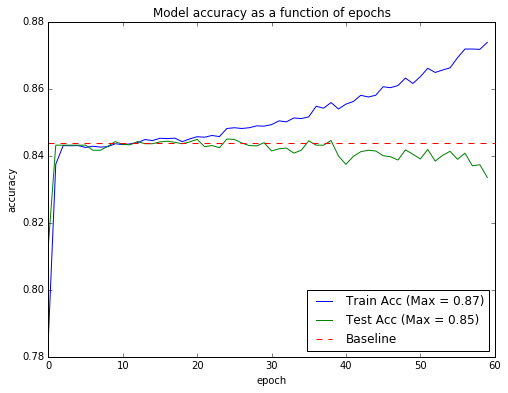

In [24]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)], 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC)

We clearly start to overfit ar about epoch 50, at which point test accuracy dips because we're starting to model noise and training accuracy increases. At its best, out model is about 83% accurate on our test data.

# Model 2: 
* 3 convolution layers & 3 pool layers
* 8 filters applied to each convolution layer
* Convolution kernels of size 3x3
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
__________

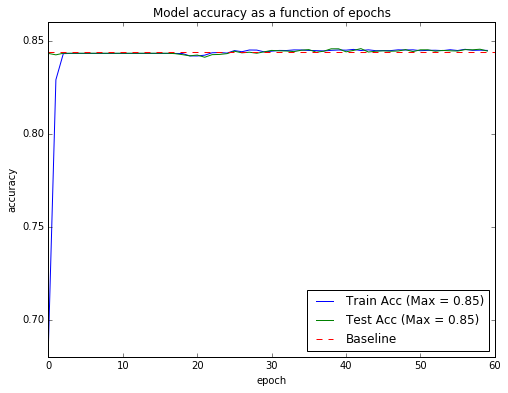

In [25]:
model = build_cnn(n_layers=3, 
                    filters=[8] * 3, 
                    kernels=[(3,3)] * 3, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_2"] = {}
model_info["model_2"]["model_history"] = model_history
model_info["model_2"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC)

While we're not overfitting in this more complicated model (i.e. more filters), we're failing to gain any more accuracy than in model 1, despite adding more layers!

# Model 3: 
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 32)          4128      
__________

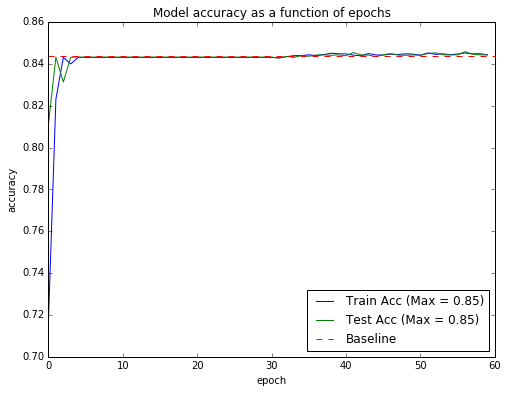

In [26]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC)

Interesting! Even after using many more layers (4 convolution layers and 4 pool layers) as well as many more filters (32 per convolution layer), we're still maxing out at about 83% accuracy, which is also our baseline accuracy (e.g. exactly what we'd get if we applied a trivial classifier which guesses all 0s).

We can also try experimenting with the learning rate and momentum of the optimizer, which is SGD. Let's just try a different combination of values for model 3 to see if we get different results.

# Model 4: 
* Same as model 3, but with a lower learning rate (0.01) and higher momentum (0.99)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 32)          4128      
__________

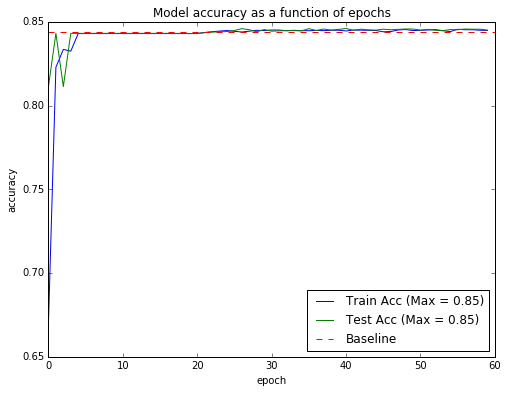

In [27]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

model.summary()
compile_cnn(model, lr=0.01, momentum=0.99)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_4"] = {}
model_info["model_4"]["model_history"] = model_history
model_info["model_4"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC)

Still getting the same accuracy as before (83%), even with a smaller learning rate.

# Model 5 (Harnessing bigger images!)
* 5 convolution layers & 5 pool layers
* [8, 16, 32, 64, 128] filters applied to layers, respectively
* Convolution kernels of size 3, 3
* relU activation function

In [55]:
img_rows, img_cols = 256, 256
dir_name = "all_nn_ready_images_" + str(img_rows) + "_" + str(img_rows)

# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("all_train_imgs/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and convert to greyscale
        im = Image.open("all_train_imgs/" + img_name).convert("L")
        out = im.resize((img_rows, img_cols))
        
        try:
            out.save(dir_name + "/" + img_name)
        except:
            os.mkdir(dir_name)
            out.save(dir_name + "/" + img_name)
            
# load image matrices into memory
x_train_big = np.array([np.asarray(Image.open(dir_name + "/" + str(m_id) + ".jpg")) for m_id in train_ids])
x_test_big =  np.array([np.asarray(Image.open(dir_name + "/" + str(m_id) + ".jpg")) for m_id in test_ids])
x_train_big, x_test_big, input_shape_big = reshape(x_train_big, x_test_big, img_rows, img_rows)

x_train shape: (1813, 256, 256, 1)
1813 train samples
778 test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 255, 255, 8)       40        
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 126, 126, 16)      528       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 62, 62, 32)        2080      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 30, 30, 64)        8256      
__________

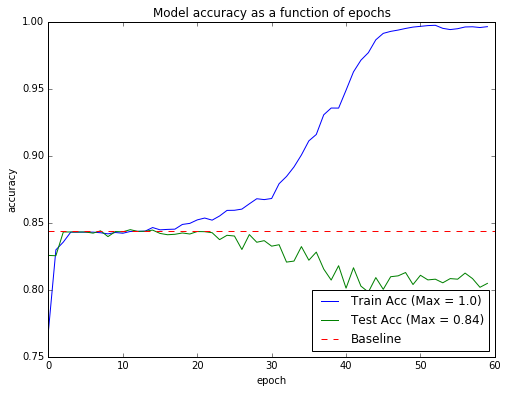

In [56]:
model = build_cnn(n_layers=4, 
                    filters=[8, 16, 32, 64],
                    kernels=[(2,2)] * 4, 
                    a_func='relu',
                  input_shape = input_shape_big)

model.summary()
compile_cnn(model, lr=0.01, momentum=0.99)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_big, 
                                           y_train=y_train,
                                           x_test=x_test_big,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_5"] = {}
model_info["model_5"]["model_history"] = model_history
model_info["model_5"]["model_score"] = model_score

plot_acc(model_history, baseline=BASELINE_ACC)

**Insights:** Even using huge images and many layers doesn't seem to get us past baseline accuracy.

It seems like the problem might be this: we have 17 labels, and our entire label matrix is incredibly sparse. It's 84% 0's, meaning that our prediction problem is looking for haystack needles. What we might want to do to decrease the sparsity of this dataset is collapse our 17 genres into a handful of categories. 

For instance, we could collapse "War" and "Horror" into "Scary". This will help us decrease the number of labels in our label matrix, which might finally get our neural net above the baseline of 84%.

Here's how we'll do the split: We'll create a new category, "Heartbeat", which will represent movies that make your heart beat quickly (romance, adventure, horror, crime, thriller etc.)

We'll also do "Lighthearted" for light hearted movies (music, comedy, family, fantasy, etc.)

And lastly, we'll have a category for "other" movies that have genres which are neither categorically lighthearted or inherently exciting.

* 'TV Movie', => Other
* 'Music', => Lighthearted
* 'Adventure' => Heartbeat
* 'Fantasy', => Heartbeat
* 'Animation', => Heartbeat
* 'Drama', => Heartbeat
* 'Action', => Heartbeat
* 'History', => Other
* 'Comedy', => Lighthearted
* 'War', => Heartbeat
* 'Horror', => Heartbeat
* 'Western', => Other
* 'Romance', => Heartbeat
* 'Family', => Lighthearted
* 'Crime', => Heartbeat
* 'Thriller' => Heartbeat

In [21]:
column_names = {'12': 'heartbeat',
 '14': 'heartbeat',
 '16': 'lighthearted',
 '18': 'heartbeat',
 '27': 'heartbeat',
 '28': 'heartbeat',
 '35': 'lighthearted',
 '36': 'other',
 '37': 'other',
 '53': 'heartbeat',
 '80': 'heartbeat',
 '10402': 'lighthearted',
 '10749': 'heartbeat',
 '10751': 'lighthearted',
 '10752': 'heartbeat',
 '10770': 'other'}

Great, now that we've reassigned into fewer labels, lets recreate y_test and y_train...

In [110]:
curr_df["other"] = ""
curr_df["heartbeat"] = ""
curr_df["lighthearted"] = ""

for index, row in curr_df.iterrows():
    if row["36"] == 1 or row["37"] == 1 or row["10770"] == 1:
        curr_df.set_value(index, "other", 1)
    else:
        curr_df.set_value(index, "other", 0)
        
    if row["12"] == 1 or row["14"] == 1 or row["18"] == 1 or row["27"] == 1 or row["28"] == 1 or row["53"] == 1 or row["80"] == 1 or row["10749"] == 1 or row["10752"] == 1:
        curr_df.set_value(index, "heartbeat", 1)
    else:
        curr_df.set_value(index, "heartbeat", 0)
        
    if row["16"] == 1 or row["35"] == 1 or row["10402"] == 1 or row["10751"] == 1:
        curr_df.set_value(index, "lighthearted", 1)
    else:
        curr_df.set_value(index, "lighthearted", 0)

In [112]:
# these are the column names of the multilabel matrix
label_names = ["other", "heartbeat", "lighthearted"]

updated_y_train = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in train_ids])
updated_y_test  = np.array([curr_df[curr_df.movie_id == movie_id][label_names].values[0] for movie_id in test_ids])

# should be (num_samples, num_labels)
print "y_train shape:", updated_y_train.shape
print "y_test shape:", updated_y_test.shape

y_train shape: (1813, 3)
y_test shape: (778, 3)


In [113]:
updated_y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ..., 
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]], dtype=object)

Looks correct! 3 labels instead of 17.

In [136]:
a, b = np.unique(updated_y_train[:,0], return_counts=True)
a, b 

(array([0, 1], dtype=object), array([1536,  277]))

Guessing 0 for the above column ("other") gives a baseline of 84%.

In [139]:
c, d = np.unique(updated_y_train[:,1], return_counts=True)
c, d

(array([0, 1], dtype=object), array([ 137, 1676]))

Guessing 1 for the above column ("heartbeat") gives a baseline of 92%.

In [140]:
e, f = np.unique(updated_y_train[:,2], return_counts=True)
e, f

(array([0, 1], dtype=object), array([1200,  613]))

Guessing 0 for the above column ("lighthearted") gives a baseline of 66%.

Averaging the three baselines, we get roughly:

In [143]:
(1.0 * b[0]/ sum(b) + 1.0 * d[1] / sum(d) + 1.0 * f[0] / sum(f)) / 3

0.8111785254642397

This means that we could effectively guess 0 for the first, 1 for the second, and 0 for the third column and get 80% accuracy.

The above are the value counts for all three columsn. The first column, "other", has a lot of 0s and few 1s, the second column, "heartbeat", has a lot of 1s but few 0s, and the third column, "lighthearted", has many 0s and a lot, but not too many 1s.

In [114]:
vals, counts = np.unique(updated_y_train, return_counts=True)
vals, counts

(array([0, 1], dtype=object), array([2873, 2566]))

Awesome! Looks like our data overall is a bit more dense now. 0s don't dominate the label matrix now, meaning that a trivial classifier would still guess all 0s, but the data is much more balanced. The new accuracy is:

In [134]:
UPDATED_BASELINE_ACC = 1.0 * counts[0] / sum(counts)
UPDATED_BASELINE_ACC

0.5282220996506711

**That said, this might be an incorrect way to calculate baseline accuracy. A trivial classifier for a multilabel problem likely guesses the most frequent value for each label, as opposed to the most frequent value overall. Thus, the real baseline accuracy is probably an average of the baseline accuracies for each label. Thus, our real baseline accuracy is about 80%**

In [144]:
UPDATED_BASELINE_ACC = (1.0 * b[0]/ sum(b) + 1.0 * d[1] / sum(d) + 1.0 * f[0] / sum(f)) / 3
UPDATED_BASELINE_ACC

0.8111785254642397

Now let's take model 3 again (See above for details), and instead train it on our dense reponse matrix!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 2, 2, 32)          4128      
__________

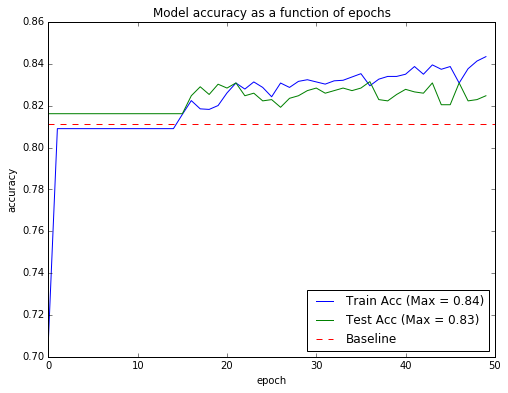

In [147]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu',
                    n_labels = 3)

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=updated_y_train,
                                           x_test=x_test,
                                           y_test=updated_y_test, 
                                           batch_size=batch_size, 
                                           epochs=50)

model_info["model_3_updated"] = {}
model_info["model_3_updated"]["model_history"] = model_history
model_info["model_3_updated"]["model_score"] = model_score

plot_acc(model_history, baseline=UPDATED_BASELINE_ACC)

Looks like our model is now having an easier time exceeding the baseline! This is beacuse our label space is much more dense, so there's not as much of a needle in a haystack problem anymore

Let's try model 1 from above on this new data...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1800)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                115264    
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 195       
Total params: 115,539.0
Trainable params: 115,539.0
Non-trainable params: 0.0
_________________________________________________________________
('Test loss:', 0.47741260358484361)
('Test accuracy:', 0.81019710912189635)


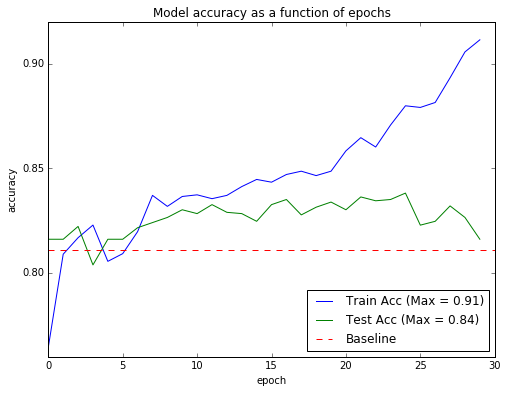

In [150]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)], 
                    a_func='relu',
                     n_labels = 3)

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=updated_y_train,
                                           x_test=x_test,
                                           y_test=updated_y_test, 
                                           batch_size=batch_size, 
                                           epochs=30)


model_info["updated_model_1"] = {}
model_info["updated_model_1"]["model_history"] = model_history
model_info["updated_model_1"]["model_score"] = model_score

plot_acc(model_history, baseline=UPDATED_BASELINE_ACC)

Let's also try changing the learning rate (i.e. model 4 from above)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 31, 31, 32)        160       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 32)          4128      
__________

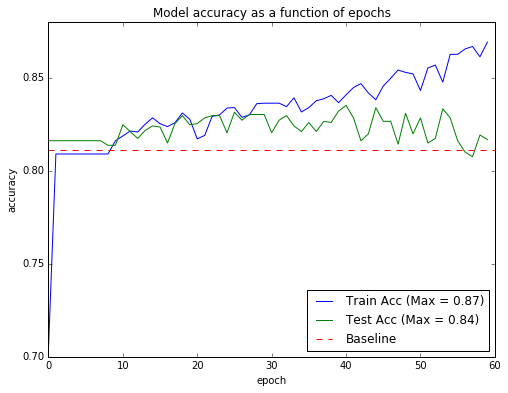

In [151]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu',
                 n_labels = 3)

model.summary()
compile_cnn(model, lr=0.01, momentum=0.99)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=updated_y_train,
                                           x_test=x_test,
                                           y_test=updated_y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["updated_model_4"] = {}
model_info["updated_model_4"]["model_history"] = model_history
model_info["updated_model_4"]["model_score"] = model_score

plot_acc(model_history, baseline=UPDATED_BASELINE_ACC)

Still beating the baseline, but just by a handful of percentage points. Maybe it's not worth it to lower the learning rate, because it takes much more time to run.

# Discussion of the results, how much improvement you gained with fine tuning, etc.

## Insights from tuning our built-from-scratch CNN

We built our from-scratch Convolutional Neural Network under the general premise that deeper networks (i.e. those with more layers) are better, given that we have the computational capacity and data size to support this increased model complexity.

We tried out many different models at first. For example:

#### Model 1: 
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

#### Model 2
* 3 convolution layers & 3 pool layers
* 8 filters applied to each convolution layer
* Convolution kernels of size 3x3
* relU activation function

#### Model 3
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

#### Model 4
* Same as model 3, but with a lower learning rate (0.01) and higher momentum (0.99)

#### Model 5 (Harnessing bigger images!) - 256x256 images
* 5 convolution layers & 5 pool layers
* [8, 16, 32, 64, 128] filters applied to layers, respectively
* Convolution kernels of size 3, 3
* relU activation function

**Insights learned up to this point:** We manually tried various parameters in the first 5 parameters, from increasing the numebr of layers (both convolution and max pool layers), changing the number of filters we used to convolv each layer, changing the kernel size of these filters, lowering the learning rate, increasing momentum, and, lastly, as a hail mary, increasing image size to 256x256.

We were never able to increase the accuracy past the baseline, which is the number representing the accuracy of a trivial classifier which guesses all 0.

This is likely because the label matrix is incredibly sparse and is roughly 82% 0, meaning that our multi-label problem is a needle-in-the-haystack problem.

To fix this, we'd likely need way more training data so that we can actually find patterns in the labels. After all, we had about 17 labels total in the first 5 models. 

Instead of increasing training data, we tried to make our task slightly more teneble --> we collapsed all 17 genres into 3 more general genres: "heartbeat", which represents movies which usually make your heart race, "lighthearted", which represents movies which are generally lighthearted and fun or romantic, and "other", which are movies that are usually not lighthearted or innately exciting. 

After collapsing our labels into three columns, we tried various models again:

* Model 3
* Model 1
* Model 4

What we found is that Models 1 and 4 got 84% accuracy, while the baseline accuracy was about 80%, meaning that we successfully were able to supercede the baseline! This is even more impressive when you consider that the new label data (that is, the label data with the three new genre categories) is about 50% 0s and 1s, so an ultra-trivial classifier would get just about 50% of the labels correctly. That said, the average of a trivial classifier's accuracy for each column separately gives about 80% accuracy in total, and we chose to use this more strict baseline because it seems more likely that this is what a trivial neural net would do.

In the end, our best, most parsimonious model was model 1 and had parameters:

* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function for the convolution layers
* .1 learning rate and .9 momentum for the SGD optimization

One thing that suprised us is that we only needed 1 convolution layer and 1 max pool layer to get peak accuracy, and using more layers didn't seem to improve accuracy much more. Our work over the next week will try to explore why this is, and whether there are other parameters that we might want to try tuning as well!

# Exploratory Idea: Let's train a model with color images instead of grayscale

In [ ]:
# convert each normal poster to a 32x32 grayscale poster
for img_name in os.listdir("all_train_imgs/"):
    ## This line added to avoid hidden files on mac (Stephen)
    if not img_name.startswith('.'):
        # read in an image and leave in color
        im = Image.open("all_train_imgs/" + img_name)
        out = im.resize((img_rows, img_cols))
        out.save("all_nn_ready_images_color/" + img_name)

In [ ]:
# gets all movie ids for the color images
m_ids_color = map(int, map(lambda x: x[:-4], os.listdir("all_nn_ready_images_color")))

# shuffle the ids to get a random sample
np.random.shuffle(m_ids_color)
train_size = int(math.floor(.7 * len(m_ids_color)))

In [ ]:
# get the movie_ids (each of which has an image in "nn_images_ready/"
# which is ready to be put through the neural net
train_ids_color = m_ids_color[:train_size]
test_ids_color = m_ids_color[train_size:]

In [ ]:
# load image matrices into memory
x_train_color = np.array([np.asarray(Image.open("all_nn_ready_images_color/" + str(m_id) + ".jpg")) for m_id in train_ids_color])
x_test_color =  np.array([np.asarray(Image.open("all_nn_ready_images_color/" + str(m_id) + ".jpg")) for m_id in test_ids_color])

In [ ]:
# output should be (num_images, img_height, img_width)
print "x_train shape:", x_train_color.shape
print "x_test shape:", x_test_color.shape

In [ ]:
# code borrowed from Keras_CNN lab

# now we need to reshape x_train and x_test so that they work with CNNs
# Following the example in "labs/Keras_CNN.ipynb", this needs to be an array 
# of images with shape determined by the backend, including the depth dimension,
# which is 1 for greyscale

# x_train is of shape n_samples x 32 x 32
# for a CNN we want to keep the image shape
# need to explicitly tell keras that it is a gray value image
# so each image is 32x32x1 not 32x32x3
if K.image_data_format() == 'channels_first':
    x_train_color = x_train_color.reshape(x_train_color.shape[0], 3, img_rows, img_cols)
    x_test_color = x_test_color.reshape(x_test_color.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train_color = x_train_color.reshape(x_train_color.shape[0], img_rows, img_cols, 3)
    x_test_color = x_test_color.reshape(x_test_color.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [ ]:
# normalize image values to [0,1]
x_train_color = x_train_color.astype('float32')
x_test_color = x_test_color.astype('float32')
x_train_color /= 255
x_test_color /= 255

print "x_train shape color:", x_train_color.shape
print x_train_color.shape[0], "train samples color"
print x_test_color.shape[0], "test samples color"

# Color Model 1: 
* 1 convolution layer & 1 pool layer
* 8 filters applied to convolution layer
* Convolution kernels of size 3x3
* relU activation function

In [ ]:
model = build_cnn(n_layers=1, 
                    filters=[8], 
                    kernels=[(3,3)], 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_color, 
                                           y_train=y_train_color,
                                           x_test=x_test_color,
                                           y_test=y_test_color, 
                                           batch_size=batch_size, 
                                           epochs=60)


model_info["model_1"] = {}
model_info["model_1"]["model_history"] = model_history
model_info["model_1"]["model_score"] = model_score

plot_acc(model_history)

# Color Model 2: 
* 3 convolution layers & 3 pool layers
* 8 filters applied to each convolution layer
* Convolution kernels of size 3x3
* relU activation function

In [ ]:
model = build_cnn(n_layers=3, 
                    filters=[8] * 3, 
                    kernels=[(3,3)] * 3, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train_color, 
                                           y_train=y_train,
                                           x_test=x_test_color,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_2"] = {}
model_info["model_2"]["model_history"] = model_history
model_info["model_2"]["model_score"] = model_score

plot_acc(model_history)

# Color Model 3: 
* 4 convolution layers & 4 pool layers
* 32 filters applied to convolution layer
* Convolution kernels of size 2, 2
* relU activation function

In [ ]:
model = build_cnn(n_layers=4, 
                    filters=[32] * 4, 
                    kernels=[(2,2)] * 4, 
                    a_func='relu')

model.summary()
compile_cnn(model)

model_history, model_score = train_cnn(model=model, 
                                           x_train=x_train, 
                                           y_train=y_train,
                                           x_test=x_test,
                                           y_test=y_test, 
                                           batch_size=batch_size, 
                                           epochs=60)

model_info["model_3"] = {}
model_info["model_3"]["model_history"] = model_history
model_info["model_3"]["model_score"] = model_score

plot_acc(model_history)

## Model Discussion
Here we see that our color models perform similarly to those in grayscale. Here, then, we see that adding color is not significant in predicting posters and that grayscale coding of the color is probably sufficient in encapsulating the information. 